In [1]:
import math, random
from collections import deque
import gym
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from itertools import count
import torch.optim as optim

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

### Model Architecture, Deep Q-Network

In [2]:
class DQN_Linear(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN_Linear, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(n_observations, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions))

    def forward(self, x):
        return self.layers(x)

In [3]:
def plot(ep, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Episode %s. reward: %s' % (ep, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

## Training

In [4]:
class replayBuffer():
    """Stores the transitions observed"""
    
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        """Push the new SARS into the buffer"""
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, minibatch_size):
        """Sample random minibatch of transitions"""
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, minibatch_size))
        return state, action, reward, next_state, done
    
    def __len__(self):
        """return the length of the memory buffer"""
        return len(self.buffer)

In [5]:
def chose_action(state):
    global n_steps
    
    eps_greedy = EPS_END + (EPS_0 - EPS_END) * math.exp(-1. * n_steps / EPS_DECAY)
    #eps_greedy = 0.2
    
    n_steps += 1
    if random.random() > eps_greedy:
        """Pick the best action, no back-propagation"""
        with torch.no_grad():
            return policy_net(torch.FloatTensor(state)).max(0)[1]
    else:
        """Takne a random action"""
        return torch.tensor(random.randrange(n_actions))

In [6]:
def optimize_model():
    if len(replay_buffer) > BATCH_SIZE:
        """state, action, reward, next_state, done = replay_buffer.sample(BATCH_SIZE)
        
        state_batch = torch.cat(tuple((map(lambda a: torch.tensor([a]), state)))).float()
        next_state_batch = torch.cat(tuple((map(lambda a: torch.tensor([a]), next_state)))).float()
        action_batch = torch.cat(tuple((map(lambda a: torch.tensor([[a]]), action))))
        reward_batch = torch.cat(tuple((map(lambda a: torch.tensor([a]), reward))))"""
        
        
        state, action, reward, next_state, done = replay_buffer.sample(BATCH_SIZE)
        state_batch      = autograd.Variable(torch.FloatTensor(np.float32(state)))
        with torch.no_grad():
            next_state_batch = autograd.Variable(torch.FloatTensor(np.float32(next_state)))
        action_batch     = autograd.Variable(torch.LongTensor(action))
        reward_batch     = autograd.Variable(torch.FloatTensor(reward))
        done_batch       = autograd.Variable(torch.BoolTensor(done))

        non_final_mask = ~done_batch
        q_value = policy_net(state_batch).gather(1, action_batch.unsqueeze(1))
        
        # final state have a reward of 0 
        next_q_value = torch.zeros(BATCH_SIZE)
        next_q_value[non_final_mask] = frozen_net(next_state_batch[non_final_mask]).max(1)[0].detach()
    
        expected_q_value = (next_q_value * GAMMA) + reward_batch
    
    
        #loss  = F.smooth_l1_loss(q_value.squeeze(), expected_q_value)
        #loss = loss_func (q_value.squeeze(), expected_q_value)
        loss = (q_value.squeeze() - expected_q_value).pow(2).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        return loss   

In [7]:
def train(env, n_episodes):
    losses = []
    all_rewards = []
    ep_loss = 0
    
    for i_episode in range(n_episodes):
        state = env.reset()
        episode_reward = 0
        
        for t in count():
            action = chose_action(state)
            next_state, reward, done, info = env.step(action.item())
            episode_reward += reward
            
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state 
            
            if n_steps > BUFFER_SIZE:
                ep_loss = optimize_model()
                losses.append(ep_loss)
                
                if n_steps % UPDATE_FREQ == 0:
                    frozen_net.load_state_dict(policy_net.state_dict())
                    
            if done:
                all_rewards.append(episode_reward)
                break
                
        if i_episode % PRINT_EPI_FREQ == 0:
            plot(i_episode, all_rewards, losses)
            print('Total steps: {} \t Episode: {} \t Length Episode: {} \t Episode reward: {} \t Loss: {}'.format(n_steps, i_episode, t, episode_reward, ep_loss))
    
    env.close()
    return

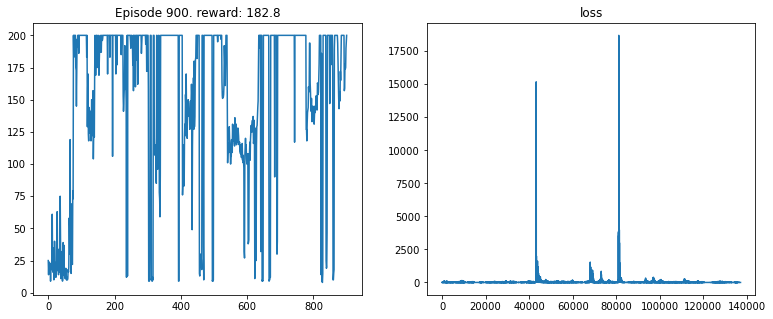

Total steps: 138013 	 Episode: 900 	 Length Episode: 199 	 Episode reward: 200.0 	 Loss: 0.05331810563802719


In [20]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
GAMMA = 0.98
EPS_0 = 1.0
EPS_END = 0.02
EPS_DECAY = 2000
UPDATE_FREQ = 10
PRINT_EPI_FREQ = 100
LR = 0.003

env = gym.make('CartPole-v0')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

replay_buffer = replayBuffer(BUFFER_SIZE)

n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]

policy_net = DQN_Linear(n_observations, n_actions).to(device)
frozen_net = DQN_Linear(n_observations, n_actions).to(device)

first_policy_net = DQN_Linear(n_observations, n_actions).to(device)
first_policy_net.load_state_dict(policy_net.state_dict())

frozen_net.load_state_dict(policy_net.state_dict())
frozen_net.eval()

optimizer = optim.Adam(policy_net.parameters())

n_steps = 0


train(env, 1000)

### Tests

In [25]:
from itertools import count
import time

for i_episode in range(5):
    observation = env.reset()
    for t in range(100):
        time.sleep(0.02)
        env.render()
        #print(observation)
        action = policy_net(torch.FloatTensor(observation)).max(0)[1].view(1,1)
        # print(policy_net(torch.FloatTensor(observation)).data)
        observation, reward, done, info = env.step(action.item())
    print('Steps : ', t)
env.close()

Steps :  99
Steps :  99
Steps :  99
Steps :  99
Steps :  99
